<a href="https://colab.research.google.com/github/jihyeon602/CV-practice/blob/main/%5B%EC%8B%A4%EC%8A%B52%5D_%EB%8F%84%EB%A1%9C%EC%A3%BC%ED%96%89_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A5%BC_%ED%99%9C%EC%9A%A9%ED%95%9C_Instance_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [실습2] 도로주행 데이터를 활용한 Instance Segmentation

## 라이브러리 import
PyTorch 및 관련 라이브러리들과 이미지 처리에 특화된 라이브러리 등을 import합니다.

* `torch, torchvision`: PyTorch 및 이미지 처리를 위한 표준 라이브러리입니다.
* `segmentation_models_pytorch`: 다양한 종류의 세그멘테이션 모델을 제공하는 라이브러리입니다.
* `albumentations`: 이미지 증강 및 변환을 위한 라이브러리입니다.
* `sklearn.model_selection.KFold`: 데이터를 K개의 부분으로 나누어 교차 검증을 수행하는 데 사용됩니다.
* `pycocotools.mask`: COCO 데이터셋 형식의 마스크 처리를 위한 도구입니다.
* `matplotlib.pyplot, PIL.Image`: 이미지 세그멘테이션 결과를 시각적으로 확인하기 위해 사용됩니다.

In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
# import pytorch
import torch
from torch.optim import lr_scheduler

# import torchvision
import torchvision
from torchvision.transforms import functional as F
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# import sementation models pytorch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils

# import albumentations
import albumentations as albu

# tools
from sklearn.model_selection import KFold
import pycocotools.mask as pycoco_mask
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import numpy as np
import hashlib
import random
import pickle
import json
import os
import datetime
import platform
import socket

## CONFIG 설정
딥 러닝 모델 학습을 위한 구성 설정을 담은 Python 딕셔너리를 생성합니다. 여기서 정의된 설정은 모델 학습 과정에서 사용됩니다.

In [ ]:
CONFIG = {
    'random_seed': 1015, # 난수 시드
    'device': 'cuda', # 사용할 gpu 지정
    'img_size': {
                        'height': 1024, # 이미지 높이
                        'width': 1920   # 이미지 너비
                    },
    'num_folds': 2,    # kfold 수
    'num_epochs': 2,  # epoch 수
    'batch_size': 4,   # batch size
    'valid_batch_size' : 2,
    'root': './',
    'models_path' : './models/instance'
}

# 전처리한 데이터를 저장할 폴더 생성
os.system(f"mkdir -p ./instance_preprocess_data")

0

## 난수 시드 고정
결과의 재현성을 보장하기 위해 다양한 난수 생성기에 대해 고정된 시드를 설정합니다. 이를 통해 모델 학습의 재현성을 보장합니다.

In [ ]:
def seed_everything(seed):
    # 파이썬의 내장 난수 생성기 시드 고정
    random.seed(seed)
    # dictinary 항목의 순서 고정
    os.environ["PYTHONHASHSEED"] = str(seed)
    # NumPy 난수 시드 고정
    np.random.seed(seed)
    # PyTorch에서 난수 시드 고정
    torch.manual_seed(seed)
    # CUDA PyTorch 난수 시드 고정
    torch.cuda.manual_seed(seed)
    # PyTorch의 컨볼루션 신경망(CNN) 연산 고정
    torch.backends.cudnn.deterministic = True

seed_everything(CONFIG['random_seed'])

## 메타데이터 불러오기
`is_label_id_list`는 튜플들의 리스트로, 각 튜플들은 라벨 ID와 해당 라벨의 설명(예: "adult", "child" 등)을 포함합니다. 이를 통해 instance segmentation에서 구분할 다양한 객체 라벨을 정의합니다.
* instance segmentation에서는 객체(thing)만을 인식하므로 객체에 대한 라벨링만을 수행합니다.

`parse_meta_data` 함수는 주어진 디렉토리 안에 있는 메타데이터 파일을 파싱하는 기능을 수행합니다. 입력받은 경로의 하위 디렉토리를 순회하며 각 디렉토리 안의 메타데이터 파일(.json 파일)을 읽고 파싱하고 이를 `ps_meta_ls` 리스트에 추가됩니다. 이 리스트는 나중에 데이터 로딩 및 처리에 사용됩니다.

In [ ]:
!unzip -q batch_02_data.zip

In [ ]:
is_label_id_list = [(40,  "adult"), (41,  "child"), (42,  "animal"), (43,  "rider"), (44,  "personal_mobility"),
                    (45,  "wheelchair"), (46,  "stroller"), (47,  "bicycle"), (48,  "bus"), (49,  "car"), (50,  "motorcycle"),
                    (51,  "trailer"), (52,  "truck"), (53,  "unknown_vehicle"), (54,  "police_car"), (55,  "police_truck"),
                    (56,  "police_bus"), (57,  "police_motorcycle"), (58,  "police_unknown"), (59,  "fire_car"), (60,  "fire_truck"),
                    (61,  "fire_bus"), (62,  "fire_unknown"), (63,  "emergency_car"), (64,  "emergency_unknown"), (65,  "yellow_vehicle")]


def parse_meta_data(root):
    date_dirs = os.listdir(f"{root}/batch_02_data")
    ps_meta_ls = []
    for date_dir in tqdm(date_dirs):
        date_dir_path = f"{root}/batch_02_data/{date_dir}"
        if date_dir == "mini_sample":
            continue
        ps_meta_parrent_path = f"{date_dir_path}/label_ps/FR-View-CMR-Wide"
        ps_meta_file_ls = os.listdir(ps_meta_parrent_path)
        for ps_meta in ps_meta_file_ls:
            if ps_meta == ".ipynb_checkpoints":
                continue
            ps_meta_path = f"{ps_meta_parrent_path}/{ps_meta}"
            f = open(ps_meta_path)
            ps_meta = json.load(f)
            ps_meta_ls.append(ps_meta)
    return np.array(ps_meta_ls)

ps_meta_array = parse_meta_data(CONFIG['root'])

100%|██████████| 10/10 [00:00<00:00, 76.57it/s]


## 데이터 셋, 데이터 로더 정의
instance segmentation을 위해 이미지와 해당 이미지의 세그멘테이션 마스크 및 타겟을 로드하고 전처리하는 커스텀 데이터셋 `InstanceSegmentationDataset`과 이를 통해 이를 통해 데이터를 로드하는 함수 `load_data`를 구현합니다.

* `InstanceSegmentationDataset` 클래스
    * `__init__`: `ps_meta_ls`를 입력받아 인스턴스 분할 데이터셋을 초기화하는 생성자입니다.
    * `get_box`: 주어진 마스크로부터 바운딩 박스를 추출합니다. 계산된 바운딩 박스는 모델 학습 중 각 객체의 위치와 크기를 학습하는 데 활용됩니다.
    * `sha256_hash`: 문자열을 입력받아 SHA-256 해시를 생성합니다. 이 메서드를 사용해 원본 이미지 경로를 인코딩하여 데이터의 키로 사용합니다.
    * `get_img_target`: 주어진 인덱스에 대한 이미지와 타겟(레이블)을 로드하고 전처리합니다. 병목 방지를 위해 한번 전처리한 데이터는 instance_preprocess_data 경로에 저장하고 필요할 때 다시 불러와서 사용합니다.
    * `__getitem__`: PyTorch 데이터셋 인터페이스의 일부로, 인덱스에 해당하는 데이터 항목을 반환합니다.
    * `__len__`: 데이터셋의 전체 길이(데이터 항목의 수)를 반환합니다.

In [ ]:
class InstanceSegmentationDataset(torch.utils.data.Dataset):

    def __init__(self, ps_meta_ls):
        self.ps_meta_ls = ps_meta_ls
        self.height = CONFIG['img_size']['height']
        self.width = CONFIG['img_size']['width']

    def get_box(self, a_mask):
        pos = np.where(a_mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1]) + 0.01
        ymin = np.min(pos[0])
        ymax = np.max(pos[0]) + 0.01
        return [xmin, ymin, xmax, ymax]

    def sha256_hash(self, input_string):
        hash_object = hashlib.sha256()
        hash_object.update(input_string.encode())
        hash_hex = hash_object.hexdigest()
        return hash_hex[:32]

    def get_img_target(self, idx):
        ps_meta = self.ps_meta_ls[idx]
        source_path = f"{CONFIG['root']}/{ps_meta['parent_path']}/{ps_meta['filename']}.png"
        hashed_string = self.sha256_hash(source_path)

        # (전처리된 이미지, 타켓) 데이터를 {hashed_string}.pickle 이라는 이름으로 저장
        preprocess_data_path = f"./instance_preprocess_data/{hashed_string}.pickle"

        # 이전에 전처리된 데이터가 존재하는 지 확인
        if os.path.exists(preprocess_data_path):
            with open(preprocess_data_path, 'rb') as f:
                # 존재하면 저장된 값을 사용
                data = pickle.load(f)
                img, target = data
            return img, target
        # 전처리된 데이터가 존재하지 않으면 새롭게 생성, 저장 후 반환

        # 이미지 array 생성
        img = Image.open(source_path)
        img = np.array(img)

        n_objects = 0
        for i, annotation in enumerate(ps_meta['annotations']):
            if annotation['isthings']:
                n_objects += 1

        masks = np.zeros((self.height, self.width, n_objects), dtype=np.uint8)
        boxes = []
        labels = []
        i = 0
        for annotation in ps_meta['annotations']:
            if annotation['isthings']:
                a_mask = pycoco_mask.decode(annotation['points'])
                a_mask = Image.fromarray(a_mask)
                a_mask = np.array(a_mask) > 0
                masks[:, :, i] = a_mask
                boxes.append(self.get_box(a_mask))
                labels.append(annotation['label_id'] - 40)
                i += 1
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.bool)
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
         }

        with open(preprocess_data_path, 'wb') as handle:
            data = (img, target)
            pickle.dump(data, handle)
        return img, target

    def __getitem__(self, idx):
        img, target = self.get_img_target(idx)
        img = F.to_tensor(img)
        target['masks'] = target['masks'].permute(2,0,1)
        return img, target

    def __len__(self):
        return len(self.ps_meta_ls)



`load_data`는 지정된 배치 크기만큼 무작위 인덱스의 데이터를 선택하여 이미지와 해당 데이터를 로드하고, 이를 배치로 묶어 반환합니다.

In [ ]:
def load_data(batchSize, segmentation_dataset):
    batch_imgs=[]
    batch_data=[]
    for i in range(batchSize):
        idx=random.randint(0,segmentation_dataset.__len__()-1)
        img, data = segmentation_dataset[idx]
        batch_imgs.append(img)
        batch_data.append(data)

    batch_imgs = torch.stack([torch.as_tensor(d) for d in batch_imgs],0)
    return batch_imgs, batch_data

## Metric 함수 정의
하나의 샘플에 존재하는 instance들의 iou score를 계산하고 평균을 구하는 함수 `get_macro_iou_score`와 f1_score를 계산하고 평균을 구하는 함수 `get_macro_f1_score`를 정의합니다.

### [TODO] mean IoU를 계산하는 함수 `get_macro_iou_score` 정의하기
IoU는 두 영역의 교집합을 합집합으로 나눈 값으로 계산됩니다. 각 클래스별 IoU값을 계산하여 리스트 iou_scores에 저장하는 코드를 완성하세요.

In [ ]:
def get_macro_iou_score(pred_masks, pred_labels, gt_masks, gt_labels):
    iou_scores = torch.zeros(len(gt_masks))

    for i, gt_mask in enumerate(gt_masks):
        gt_label = gt_labels[i]

        # 교집합 계산
        intersections = torch.zeros(len(pred_masks)).to(CONFIG['device'])
        for j, pred_mask in enumerate(pred_masks):
            if pred_labels[j] == gt_label:
                intersections[j] = (gt_mask * pred_mask).sum()

        # 합집합 계산
        union = pred_masks.sum(axis=(1, 2)) + gt_mask.sum() - intersections

        #######################################
        # [TODO] IoU 계산하기
        # 상단 지시사항에 따라 None을 지우고 코드 작성
        # 교집합이 0보다 큰 인덱스 valid의 교집합을 합집합으로 나누어 계산합니다.
        #######################################
        valid = intersections > 0
        valid_iou_scores = intersections[valid] / union[valid]

        # iou score 계산해서 리스트에 저장
        if valid_iou_scores.numel() > 0:
            iou_scores[i] = valid_iou_scores.max()

    macro_iou_score = iou_scores.mean()

    return float(macro_iou_score)

def get_macro_f1_score(pred_masks, pred_labels, gt_masks, gt_labels):
    f1_scores = torch.zeros(len(gt_masks))

    for i, gt_mask in enumerate(gt_masks):
        gt_label = gt_labels[i]

        # 교집합 게산
        intersections = torch.zeros(len(pred_masks)).to(CONFIG['device'])
        for j, pred_mask in enumerate(pred_masks):
            if pred_labels[j] == gt_label:
                intersections[j] = (gt_mask * pred_mask).sum()

        valid = intersections > 0
        pred_mask_area = pred_masks.sum(axis=(1, 2))[valid]

        # f1 score 게산하여 리스트에 저장
        if len(pred_mask_area) > 0:
            f1_scores_valid = (2 * intersections[valid]) / (pred_mask_area + gt_mask.sum())
            f1_scores[i] = f1_scores_valid.max()
        else:
            f1_scores[i] = 0  # 겹치는 부분 없으면 f1 score를 0으로 설정

    macro_f1_score = f1_scores.mean()
    return float(macro_f1_score)

배치 단위의 예측 결과(preds)와 실제 타겟(targets)을 `get_macro_iou_score`와 `get_macro_f1_score`을 활용해 배치단위 IoU와 F1 점수를 계산하고 평균을 반환합니다.

In [ ]:
def get_batch_macro_iou_score(preds, targets):
    batch_iou_scores = torch.zeros(len(preds))
    for i in range(len(preds)):
        pred = preds[i]
        target = targets[i]
        pred_masks = pred['masks']
        threshold_idx = pred['scores'] > 0.12
        pred_masks = pred_masks[threshold_idx,0,:,:]
        pred_masks = pred_masks != 0
        pred_labels = pred['labels'][threshold_idx]

        target = targets[i]
        gt_masks = (target['masks'] != 0)#.to(CONFIG['device'])
        gt_labels = target['labels']#.to(CONFIG['device'])
        batch_iou_scores[i] = get_macro_iou_score(pred_masks, pred_labels, gt_masks, gt_labels)
    return float(batch_iou_scores.mean().detach().numpy())

def get_batch_macro_f1_score(preds, targets):
    batch_f1_scores = torch.zeros(len(preds))
    for i in range(len(preds)):
        pred = preds[i]
        target = targets[i]
        pred_masks = pred['masks']
        threshold_idx = pred['scores'] > 0.12
        pred_masks = pred_masks[threshold_idx,0,:,:]
        pred_masks = pred_masks != 0
        pred_labels = pred['labels'][threshold_idx]

        target = targets[i]
        gt_masks = (target['masks'] != 0)#.to(CONFIG['device'])
        gt_labels = target['labels']#.to(CONFIG['device'])
        batch_f1_scores[i] = get_macro_f1_score(pred_masks, pred_labels, gt_masks, gt_labels)
    return float(batch_f1_scores.mean().detach().numpy())

## 모델 학습
K-fold 교차검증을 설정하고 `InstanceSegmentationDataset` 클래스를 사용하여 훈련 및 검증 데이터셋을 생성합니다. 사전학습 되어 있는 MaskRCNN 모델을 불러와 도로 주행 데이터셋을 fine-tuning하여 instance segmentation 모델을 생성합니다. 모델에 대해 Adam Optimizer와 scheduler를 설정하고 train, valid step size를 데이터셋 크기를 배치 크기로 나눈 값으로 설정합니다. 앞서 설정한 epochs만큼 학습과 검증을 반복하고 각 과정에서 CrossEntropy, iou, f1 score를 확인합니다.

### [TODO] 사전학습 모델 불러오기
* weights: pre-trained된 가중치 `MaskRCNN_ResNet50_FPN_Weights.DEFAULT` 을 불러옵니다.
* model: `maskrcnn_resnet50_fpn`모델을 초기화합니다. weights는 앞서 설정한 가중치를 사용합니다.

In [ ]:
def maskrcnn_training():
    # n_splits 만큼의 폴드 생성
    kfold = KFold(
        n_splits=CONFIG['num_folds'],
        random_state = CONFIG['random_seed'],
        shuffle = True
    )

    # n_splits 수 만큼 kfold cross validation 수행
    for fold_idx, (train_ps_meta_array_idx, valid_ps_meta_array_idx) in enumerate(kfold.split(ps_meta_array)):

        #train_fold index 생성
        train_fold = ps_meta_array[train_ps_meta_array_idx]
        #valid_fold index 생성
        valid_fold = ps_meta_array[valid_ps_meta_array_idx]

        # train dataset 생성
        train_dataset = InstanceSegmentationDataset(
                train_fold
            )
        # valid dataset 생성
        valid_dataset = InstanceSegmentationDataset(
                valid_fold
            )

        #######################################
        # [TODO] 사전학습모델 불러오기              #
        # 상단 지시사항에 따라 None을 지우고 코드 작성  #
        #######################################
        weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
        model = maskrcnn_resnet50_fpn(weights=weights)

        # 모델이 예측할 class 수를 데이터의 instance label id 수로 변경
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor=FastRCNNPredictor(in_features,
                                                        num_classes=len(is_label_id_list))

        # 모델을 gpu로 이동
        model = model.to(CONFIG['device'])

        # optimizer, scheduler 설정
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.Adam([
                dict(params=model.parameters(),
                     lr=0.0001,
                    )
            ])
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 8, 2, eta_min=1e-6)

        batch_size = CONFIG['batch_size']
        valid_batch_size = CONFIG['valid_batch_size']
        train_size = len(train_dataset)
        train_step_size = train_size // batch_size
        valid_size = len(valid_dataset)
        valid_step_size = valid_size // valid_batch_size

        print(f"Fold: {fold_idx+1}/{CONFIG['num_folds']}")
        print(f"train size: {train_size}")
        print(f"valid size: {valid_size}")
        print(f"batch size: {CONFIG['batch_size']}")
        print(f"train step size: {train_step_size}")

        for epoch in range(CONFIG['num_epochs']):
            print(f"Epoch: {epoch}")
            # train
            model.train()
            pbar = tqdm(range(train_step_size),
                        total=train_step_size,
                        desc = f"Train",
                            bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'
                       )
            running_loss = 0.
            running_iou = 0.

            for i in pbar:
                images, targets = load_data(batch_size, train_dataset) # batch size 만큼 데이터 로드
                images = list(image.to(CONFIG['device']) for image in images) # 데이터를 gpu로 이동
                targets=[{k: v.to(CONFIG['device']) for k,v in t.items()} for t in targets]

                optimizer.zero_grad() # optimizer에 적재된 이전 스텝의 기울기(gradient)를 초기화하여 미니배치마다 독립적인 업데이트를 보장
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

                losses.backward() # 역전파(backward pass) 수행
                optimizer.step() # 모델의 파라미터 업데이트

                loss_value = losses.item()
                running_loss += loss_value
                pbar.set_postfix({
                    'CrossEntropy': running_loss/(i+1),
                })

            # validation 과정에선 losses.backward() 및 optimizer.step()를 수행하지 않음
            with torch.no_grad():
                pbar = tqdm(range(valid_step_size),
                            total=valid_step_size,
                            desc = f"Valid",
                            bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'
                           )
                running_loss = 0.
                running_iou = 0.
                running_f1 = 0.

                for i in pbar:
                    images, targets = load_data(valid_batch_size, valid_dataset)
                    images = list(image.to(CONFIG['device']) for image in images)
                    targets=[{k: v.to(CONFIG['device']) for k,v in t.items()} for t in targets]
                    optimizer.zero_grad()
                    model.train() # cross entropy loss 를 계산하기 위해서 train 모드로 임시 전환
                    loss_dict = model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())
                    loss_value = losses.item()
                    running_loss += loss_value

                    model.eval()
                    preds = model(images)
                    macro_iou_score = get_batch_macro_iou_score(preds, targets)
                    macro_f1_score = get_batch_macro_f1_score(preds, targets)
                    running_iou +=  macro_iou_score
                    running_f1 += macro_f1_score

                    pbar.set_postfix({
                        'CrossEntropy': running_loss/(i+1),
                        'Iou': running_iou/(i+1),
                        'f1': running_f1/(i+1)
                    })
            scheduler.step()
        #break # 첫 번째 폴드 후에 중지하려면 이 주석을 해제

    return model

model = maskrcnn_training()

Fold: 1/2
train size: 250
valid size: 250
batch size: 4
train step size: 62
Epoch: 0


Valid: 100%|██████████| 125/125 [01:21<00:00,  1.54it/s, CrossEntropy=1.03, Iou=0.43, f1=0.538] 


Epoch: 1


Valid: 100%|██████████| 125/125 [01:02<00:00,  2.00it/s, CrossEntropy=0.909, Iou=0.491, f1=0.596]


Fold: 2/2
train size: 250
valid size: 250
batch size: 4
train step size: 62
Epoch: 0


Valid: 100%|██████████| 125/125 [01:02<00:00,  2.02it/s, CrossEntropy=1.13, Iou=0.409, f1=0.505]


Epoch: 1


Valid: 100%|██████████| 125/125 [00:58<00:00,  2.14it/s, CrossEntropy=0.933, Iou=0.47, f1=0.576] 


## 모델 예측 시각화
모델의 instance segmentation 결과를 시각화 하는 코드입니다.
* `make_colormap`: 지정된 숫자만큼의 색상을 생성하여 컬러맵을 반환합니다.
* `get_label_image`: 레이블 맵과 RGB 색상을 받아 해당 레이블에 색상을 적용한 이미지를 생성합니다. alpha 매개변수로 투명도를 조절합니다.
* `show_pred_gt_img`: 예측된 마스크(`pred_masks`)와 실제 마스크(`gt_masks`)를 원본 이미지 위에 겹쳐서 표시합니다. `make_colormap`을 사용하여 색상을 생성하고, 반복문을 통해 gt와 pred의 각 마스크에 대해 고유한 색상을 할당합니다. 이후 `get_label_image`를 활용해 원본 이미지에 segmentation 결과를 겹쳐서 출력합니다.

In [ ]:
def make_colormap(num=256):
    num += 1
    def bit_get(val, idx):
        return (val >> idx) & 1
    colormap = np.zeros((num, 3), dtype=int)
    ind = np.arange(num, dtype=int)
    for shift in reversed(list(range(8))):
        for channel in range(3):
            colormap[:, channel] |= bit_get(ind, channel) << shift
        ind >>= 3
    return colormap[1:]

def get_label_image(label_map, rgb_color, alpha):
    label_map = label_map[np.newaxis, :]
    label_image = np.concatenate(
        [label_map * rgb_color[0] / 255,
        label_map * rgb_color[1]/ 255,
        label_map * rgb_color[2]/ 255,
        (label_map == 1) * alpha],
    axis = 0).transpose(1,2,0)
    return label_image

def show_pred_gt_img(pred_masks, gt_masks, img, alpha = 0.5):
    color_num = pred_masks.shape[0] if pred_masks.shape[0] > gt_masks.shape[0] else gt_masks.shape[0]
    colors = make_colormap(color_num)
    pred_masks = pred_masks.transpose(2,0,1)
    gt_masks = gt_masks.transpose(2,0,1)
    gt_color_map = {}
    pred_color_map = {}

    pred_masks_idx_ls = list(np.arange(pred_masks.shape[0]))

    for i in range(gt_masks.shape[0]): # colormap에서 고유 색상 할당
        gt_mask = gt_masks[i]
        intersection = ((pred_masks == gt_mask) * gt_mask).sum(axis=1).sum(axis=1)
        pred_mask_idx = intersection.argmax()
        gt_color_map[i] = colors[i]
        pred_color_map[pred_mask_idx] = colors[i]
        if pred_mask_idx in pred_masks_idx_ls:
            pred_masks_idx_ls.remove(pred_mask_idx)

    for i in range(len(pred_masks_idx_ls)):
        pred_color_map[pred_masks_idx_ls[i]] = colors[i + gt_masks.shape[0]]

    plt.imshow(img) # segment map만을 확인하려면 이 부분을 주석처리
    for i in range(gt_masks.shape[0]):
        plt.imshow(get_label_image(gt_masks[i], gt_color_map[i], alpha = alpha))
    plt.title("Grount Truth")
    plt.show()

    plt.imshow(img) # segment map만을 확인하려면 이 부분을 주석처리
    for i in range(pred_masks.shape[0]):
        plt.imshow(get_label_image(pred_masks[i], pred_color_map[i], alpha = alpha))
    plt.title("Model Prediction Instance")
    plt.show()

## 시각화 데이터 설정
모델의 성능 확인에 활용할 데이터를 설정합니다. 26번 index의 이미지를 활용해 instance segmentation 결과를 확인합니다.

`InstanceSegmentationDataset` 클래스를 활용해 `ps_meta_array`를 기반으로 데이터셋 객체를 생성하고 데이터셋에서 `sample_idx`번째 샘플을 로드합니다. 로드된 샘플의 이미지를 시각화하기 위해 numpy array로 변환하고 (높이, 너비, RGB) 형식으로 변환합니다. 샘플의 마스크(ground truth mask) 역시 (높이, 너비, 레이블) 형태의 numpy array로 변환하여 각 레이블에 대한 마스크를 별도의 채널로 분리합니다.

* 인덱스를 변경하여 다른 이미지에 대한 결과를 확인할 수도 있습니다. **단 채점을 위한 제출 시에는 26번 이미지의 예측 결과를 제출해야 합니다.**

In [ ]:
sample_idx = 26 # 26번째 데이터 선택

sample_dataset = InstanceSegmentationDataset(
    ps_meta_array,
)

sample = sample_dataset[sample_idx]

sample_image = sample[0].numpy()
sample_image = sample_image.astype(float).transpose(1,2,0)
gt_masks = sample[1]['masks'].numpy()
gt_masks = gt_masks.astype(float).transpose(1,2,0)

gt_labels = sample[1]['labels'].numpy()

## 모델 시각화
학습을 수행한 모델의 결과를 시각화합니다. 모델을 평가(evaluation) 모드로 설정하여 드롭아웃 등의 설정을 비활성화하고 샘플 데이터를 텐서로 변환하여 모델에 전달합니다. 예측된 마스크와 레이블을 CPU로 가져와 numpy 배열로 변환하고 임계값 0.5보다 높은 값만을 마스크로 사용하도록 필터링합니다. 너무 많은 객체를 탐지하지 않기 위해 상위 20개의 예측 마스크를 선택하고 (높이, 너비, RGB) 형식으로 변환한 뒤 `show_pred_gt_img`을 활용하여 원본 이미지에 오버레이 하여 시각화합니다.

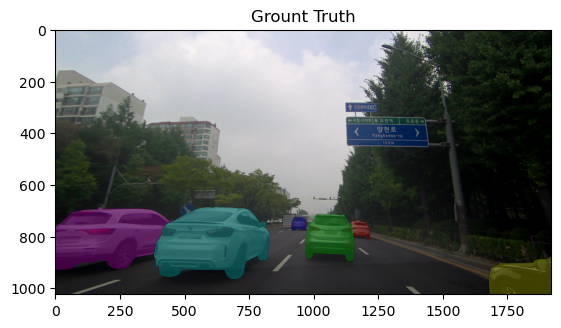

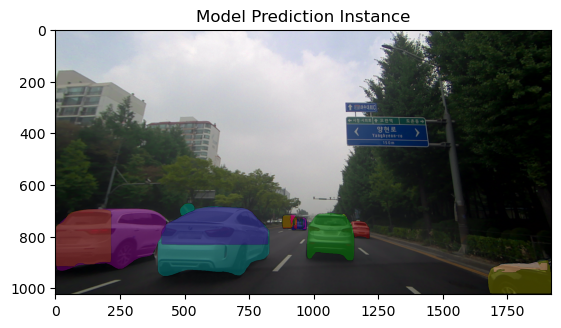

In [ ]:
# 모델 추론
model.eval()
x = torch.unsqueeze(sample[0],0).to(CONFIG['device'])
pred = model.forward(x)
pred_masks = pred[0]['masks'].detach().cpu().numpy()
pred_labels = pred[0]['labels'].detach().cpu().numpy()

# threshold 보다 높은 값만 mask로 사용
threshold = 0.5
pred_masks = (pred_masks >= threshold)
np.argsort(pred_masks.mean(axis=0).mean(axis=0))

# float 형 변환
pred_masks = pred_masks[:20,0,:,:].astype(float).transpose(1,2,0)

show_pred_gt_img(pred_masks, gt_masks, sample_image, alpha = 0.5)

학습시킨 모델을 저장해두었다가 불러와서 사용할 수도 있습니다. 추후 Panoptic segmentation에서 활용할 수 있도록 학습시킨 모델을 `custom_is_model.pth`파일로 저장합니다.

In [ ]:
torch.save(model, "custom_is_model.pth")

모델의 epoch 값을 늘려주어 학습을 반복해서 수행하면 아래와 같은 결과를 얻을 수 있습니다. epoch값을 변경해 최선의 instance segmentation 모델을 생성해보세요.

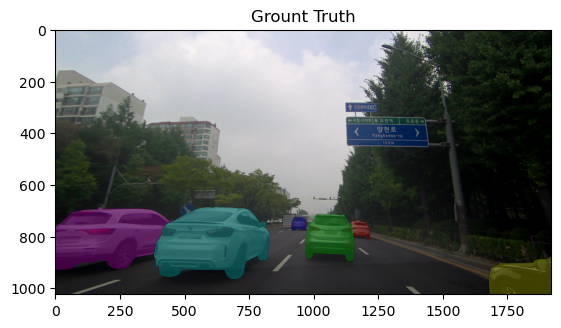

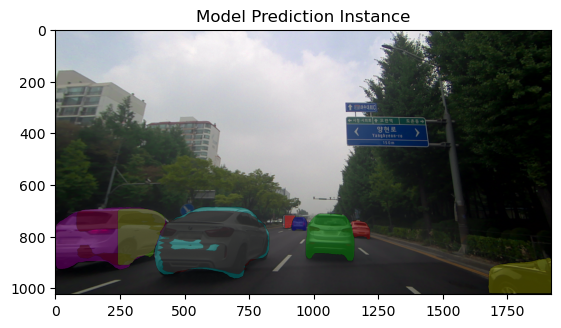

In [ ]:
# 모델 추론
best_model = torch.load(f"best_instance_segmentation_model.pth",  weights_only=False, map_location={'cuda:1': CONFIG["device"]})

best_model.eval()
bm_x = torch.unsqueeze(sample[0],0).to(CONFIG['device'])
bm_pred = best_model.forward(bm_x)
bm_pred_masks = bm_pred[0]['masks'].detach().cpu().numpy()
bm_pred_labels = bm_pred[0]['labels'].detach().cpu().numpy()

# threshold 보다 높은 값만 mask로 사용
threshold = 0.5
bm_pred_masks = (bm_pred_masks >= threshold)
np.argsort(bm_pred_masks.mean(axis=0).mean(axis=0))

# float 형 변환
bm_pred_masks = bm_pred_masks[:20,0,:,:].astype(float).transpose(1,2,0)

show_pred_gt_img(bm_pred_masks, gt_masks, sample_image, alpha = 0.5)

### [TODO] 최선의 모델 생성하기
코드의 맨 위로 올라가 `CONFIG`에서 **num_epochs', 'batch_size'** 등을 수정한 뒤 다시 모델을 학습시킵니다. 최선의 모델을 찾아 `model`에 저장하세요. 최종 `model`의 mIoU값이 0.5 이상이어야 합니다.

---

# 채점
채점을 위한 코드입니다. 아래 코드를 실행하시고 우측 상단의 제출 버튼을 누르면 채점이 진행됩니다.
* **채점을 위해선 26번 이미지에 대한 예측 결과가 제출되어야 합니다. 올바른 채점을 위해 `sample_idx`를 26으로 설정하고 코드를 실행한 뒤 제출하세요**
* 위의 실습 지시사항을 모두 올바르게 수행해야 채점이 진행됩니다.
* 채점 코드를 임의로 수정할 시 채점이 올바르게 진행되지 않습니다.

In [ ]:
import inspect
import json

target=sample[1]
pred_masks = bm_pred[0]['masks']
threshold_idx = bm_pred[0]['scores'] > 0.12
pred_masks = pred_masks[threshold_idx,0,:,:]
pred_masks = pred_masks != 0
pred_labels = bm_pred[0]['labels'][threshold_idx]
cal_gt_masks = (target['masks'] != 0).to(CONFIG['device'])
cal_gt_labels = target['labels'].to(CONFIG['device'])

student_answers = {}
student_answers["problem_1"] = float(get_macro_iou_score(pred_masks, pred_labels, cal_gt_masks, cal_gt_labels))
student_answers["problem_2"] = inspect.getsource(maskrcnn_training)
# pred에는 26번 이미지에 대한 예측 결과가 저장되어 있어야 합니다.
pred_cpu = [{k: v.to('cpu').detach() for k, v in item.items()} for item in pred]
torch.save(pred_cpu, 'sub_pred.pt')

with open("result.json", "w") as f:
    json.dump(student_answers, f)